# Outreachy Datascience
### Issue 2
#### Device Failure: Reduce Number of Telemetry Attributes
The current telemetry payload is too large. We need a good representation that approximates the dataset, with a reduced number of columns.
-  What are some methods for reducing the size of the dataset?
-  What is the trade-off between dataset size and fidelity to original dataset


In [1]:
#import libraries for faster performance and easier code.
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
#load csv and assess data
df = pd.read_csv('../device-failure/device_failure.csv')
df.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
0,15001,S1F01085,215630672,56,0,52,6,407438,0,0,7,0
1,15001,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0
2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0
3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0
4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0


## Assess Dataset 
The following assessment will figure out if there are any issues with the dataset such as abnormal values, empty cells etc


In [3]:
#length
len(df)

124494

In [4]:
#number of columns
len(df.columns)

12

In [5]:
#check for null columns
df.isnull().any()

date          False
device        False
attribute1    False
attribute2    False
attribute3    False
attribute4    False
attribute5    False
attribute6    False
attribute7    False
attribute8    False
attribute9    False
failure       False
dtype: bool

In [6]:
#check for duplicates 
len(df[df.duplicated() == True])

0

This data is relatively clean, with no duplicated records and no null cells. We shall have to check if any of the attritubes have high correlation to the failure

I thought of separating the date column. However, there are advantages to not:
-  Grouping becomes easy as these are integers to work with 
-  Sorting also becomes easy because of the same thing
-  It keeps the size of the dataset small.

However, it does require more knowledge on the part of the programmer to run with a date as this

In [7]:
#plot the correlation matrix 

corr = df[df.columns[2:]].corr()
corr.style.background_gradient().set_precision(2)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
attribute1,1,-0.0042,0.0037,0.0018,-0.0034,-0.0015,0.00015,0.00015,0.0011,0.002
attribute2,-0.0042,1,-0.0026,0.15,-0.014,-0.026,0.14,0.14,-0.0027,0.053
attribute3,0.0037,-0.0026,1,0.097,-0.0067,0.009,-0.0019,-0.0019,0.53,-0.00095
attribute4,0.0018,0.15,0.097,1,-0.0098,0.025,0.046,0.046,0.036,0.067
attribute5,-0.0034,-0.014,-0.0067,-0.0098,1,-0.017,-0.0094,-0.0094,0.0059,0.0023
attribute6,-0.0015,-0.026,0.009,0.025,-0.017,1,-0.012,-0.012,0.021,-0.00055
attribute7,0.00015,0.14,-0.0019,0.046,-0.0094,-0.012,1,1,0.0069,0.12
attribute8,0.00015,0.14,-0.0019,0.046,-0.0094,-0.012,1,1,0.0069,0.12
attribute9,0.0011,-0.0027,0.53,0.036,0.0059,0.021,0.0069,0.0069,1,0.0016
failure,0.002,0.053,-0.00095,0.067,0.0023,-0.00055,0.12,0.12,0.0016,1


We have to reduce the size of the dataset by reducing the number of columns and this can be done by checking the correlation of all variables with failure variable. We can thus, see that attribute2, attribute4, attribute7 and attribute8 are the most important in making an analysis. Other columns are not that important and may not be used. The advantage of using correlation over covariance is that it is normalised and not dependent on the scales of the column values.

Another way to reduce dimenstionality is via the low variance filter 

In [8]:
df.var(axis=0)

date          6.148451e+03
attribute1    4.964555e+15
attribute2    4.750908e+06
attribute3    3.450207e+04
attribute4    5.247997e+02
attribute5    2.541799e+02
attribute6    9.830923e+09
attribute7    5.530784e+01
attribute8    5.530784e+01
attribute9    3.664377e+04
failure       8.507285e-04
dtype: float64

However, apart from the failure column (which is the main column), variance of all columns is quite high. 

Random Forest is another way to perform dimenstionality reduction

In [9]:
from sklearn.ensemble import RandomForestRegressor
new_df=df.drop(['device','failure'], axis=1) # dropping since all unique values
target = df['failure']
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(new_df,target)

/home/sando/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

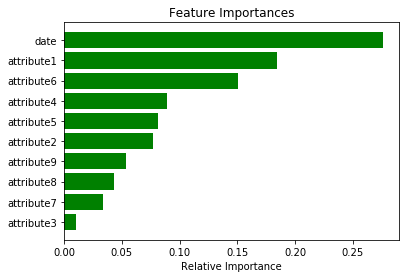

In [10]:
features = new_df.columns
importances = model.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Here we can see more precisely, how important each feature is sorted based on impurity. However, these sorted importances are considered after the correlation filter because it is biased towards variables with more categories like date. 

Other ways that can be used to check for relationships:
-  missing values filter, but we cannot use this since there are no missing values in the data set
-  plot variables
-  backward and forward feature selection


In [11]:
#separtaing the data to proof timing improvements based on correlation filter.
df_small = df.drop(['device','attribute3','attribute5','attribute6','attribute9'], axis=1)

In [12]:
%%timeit
df.describe()

77.9 ms ± 244 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%%timeit
df_small.describe()

48.4 ms ± 383 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit 
new_df = df[df['failure'] == 1]['attribute7']

676 µs ± 28.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
%%timeit
new_df = df_small[df_small['failure'] == 1]['attribute7']

557 µs ± 1.72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%%timeit
df.groupby(['failure']).size()

1.8 ms ± 3.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
%%timeit
df_small.groupby(['failure']).size()

1.79 ms ± 3.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


It can easily be seen that in simple functions, the larger dataframe times are almost double the smaller dataframe times. 
Even for more complex funtions, the smaller dataframe always performs better. In a time where every microsecond counts in system performance, even a 15 milisecond difference is very large. 

However, it should be noted that there is loss of data, in the smaller df. You can never be two sure that the attributes left out are not worthy (except for the device attribute as that is unique to each row). Thus, maybe a better solution would be to make two smaller dataframes; one of the important attributes and one for the unimportant attributes. 